In [1]:
from tqdm import tqdm
import seaborn as sns
from joblib import Parallel, delayed
import os
import pandas as pd
import random
from core import read_dom_table
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def extract_hmmer_data(hmm_folder, hmm_filename):
    """
    Extracts specific information (NAME, DESC, LENG) from a HMMER file and returns it as a pandas DataFrame.
    
    Parameters:
    file_path (str): The path to the HMMER file.
    
    Returns:
    pd.DataFrame: DataFrame containing the extracted data.
    """
    data = []
    with open(os.path.expanduser(hmm_folder + hmm_filename), 'r') as file:
        for line in file:
            if line.startswith('NAME') or line.startswith('LENG'):
                key, value = line.split(maxsplit=1)
                data.append((key.strip(), value.strip()))
    # Convert list of tuples to DataFrame
    df = pd.DataFrame(data, columns=['Field', 'Value'])
    df = df.pivot_table(index=df.groupby('Field').cumcount(), columns='Field', values='Value', aggfunc='first')
    df['system_gene'] = hmm_filename.split('.')[0]
    return df

In [3]:
df_hmm_dir = '~/defense-finder-models/profiles/'
hmm_name_len_list = Parallel(n_jobs=48)(delayed(extract_hmmer_data)(df_hmm_dir,f) for f in 
                                        tqdm(os.listdir(os.path.expanduser(df_hmm_dir)), position=0) if '.hmm' in f)
hmm_name_len_df = pd.concat(hmm_name_len_list)
hmm_name_len_df['LENG'] = hmm_name_len_df['LENG'].astype(int)

100%|██████████| 1019/1019 [00:05<00:00, 197.14it/s]


In [4]:
df_uniref_out = '../data/interim/df_uniref_out/'

In [5]:
hmm_results_list = Parallel(n_jobs=48)(delayed(read_dom_table)(df_uniref_out + f) for 
                                       f in tqdm(os.listdir(df_uniref_out), total=610, position=0) if '.txt' in f)
hmm_results_df = pd.concat(hmm_results_list)

611it [00:09, 62.09it/s]                         


Note: we group by query since the two QueC profiles (CBASS and Dpd) are so similar, but we could also groupby gene_system

In [6]:
hmm_results_df['env_len'] = hmm_results_df['env_to'] - hmm_results_df['env_from'] 
hmm_results_df['hmm_len'] = hmm_results_df['hmm_to'] - hmm_results_df['hmm_from']
hmm_results_df['qcov'] = hmm_results_df['hmm_len']/hmm_results_df['qlen']
hmm_results_df['tcov'] = hmm_results_df['env_len']/hmm_results_df['tlen']
filtered_hmm_results_df = hmm_results_df[(hmm_results_df['qcov'] > 0.8) & 
                                         (hmm_results_df['tcov'] > 0.8)].reset_index(drop=True)
merged_hmm_results_df = (filtered_hmm_results_df.merge(hmm_name_len_df.rename(columns={'LENG': 'qlen', 
                                                                                       'NAME': 'query'}), 
                                                       how='inner', on=['query', 'qlen']))
top_genes = (merged_hmm_results_df.sort_values('seq_score', ascending=False)
             .groupby('query')
             .head(1))

In [7]:
top_genes['env_hmm_len_dif'] = filtered_hmm_results_df['hmm_len'] - filtered_hmm_results_df['env_len']

<Axes: xlabel='env_hmm_len_dif', ylabel='Count'>

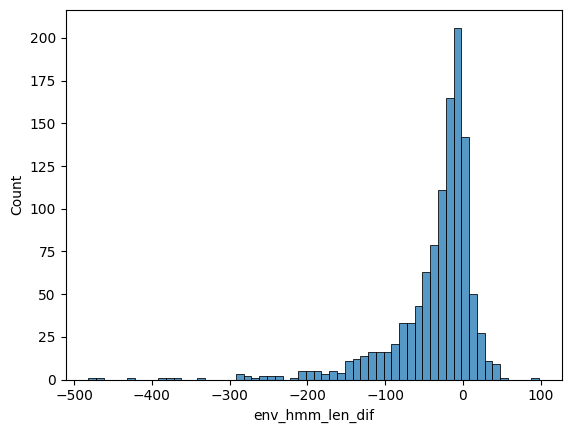

In [8]:
sns.histplot(top_genes['env_hmm_len_dif'], binwidth=10)

/home/gridsan/pdeweirdt/.conda/envs/beaker/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


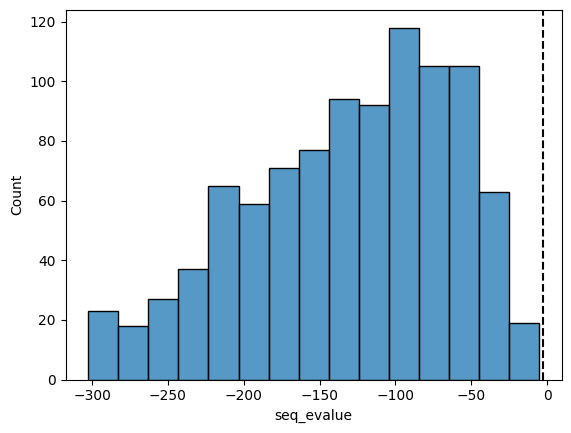

In [9]:
sns.histplot(np.log10(top_genes['seq_evalue']))
plt.axvline(-3, linestyle='dashed', color='black')

<Axes: xlabel='qcov', ylabel='Count'>

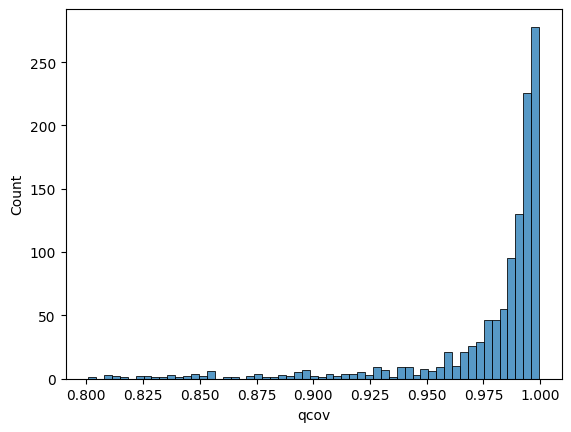

In [10]:
sns.histplot(top_genes['qcov'])

<Axes: xlabel='tcov', ylabel='Count'>

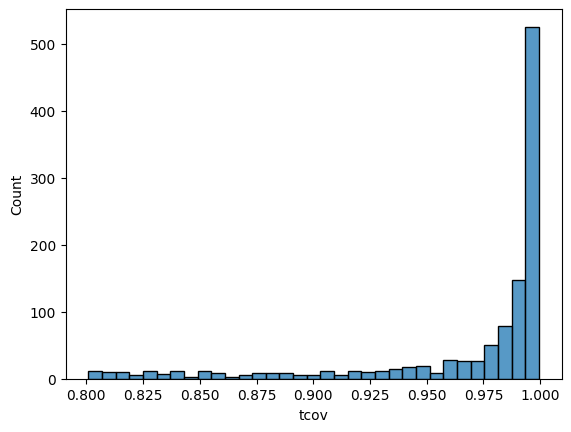

In [11]:
sns.histplot(top_genes['tcov'])

In [12]:
rep_id_f = '../data/interim/rep_df_ids.txt'

In [13]:
top_genes[['target']].to_csv(rep_id_f, index=False)

In [14]:
rep_seq_fa = '../data/interim/rep_df.faa'

In [15]:
rep_seq_fa

'../data/interim/rep_df.faa'

In [16]:
os.system(' '.join(['conda run -n beaker', 
                    'seqkit grep -f',
                    rep_id_f, 
                    '../data/interim/uniref50_chunks/uniref50.faa', 
                    '-o', rep_seq_fa]))

[INFO] 1091 patterns loaded from file



0

In [17]:
def get_hmm_desc(model):
    rand = random.randint(0, 1_000_000_000)
    temp_out = '../data/interim/temp_hmm_stat' + str(rand) + '.txt'
    system, gene = model.split('__')
    gene = gene.split('.')[0]
    os.system(' '.join(['conda run -n beaker', 'hmmstat', '~/defense-finder-models/profiles/' + model, 
                        '>', temp_out]))
    stat_df = pd.read_csv(temp_out, 
                          sep='\s+', names=['idx', 'name', 'accession', 'nseq', 'eff_nseq', 
                                            'M', 'relent', 'info', 'p relE', 'compKL'], comment='#')
    os.system('rm ' + temp_out)
    stat_df['system'] = system
    stat_df['gene'] = gene
    stat_df['description'] = stat_df.apply(lambda row: ' '.join(row[['system', 'gene', 'name']].to_list()) if row['gene'] != row['name'] else
                                           ' '.join(row[['system', 'gene']].to_list()), axis=1)
    return stat_df

In [18]:
df_info_list = Parallel(n_jobs=48)(delayed(get_hmm_desc)(model)
                                   for model in 
                                   tqdm(os.listdir('/home/gridsan/pdeweirdt/defense-finder-models/profiles/'), 
                                        position=0) if '.hmm' in model)
df_info_df = pd.concat(df_info_list)

100%|██████████| 1019/1019 [00:42<00:00, 23.97it/s]


In [19]:
merged_top_genes = (top_genes.merge(df_info_df.rename(columns={'name': 'query'}), 
                                    on='query',
                                    how='inner'))
merged_top_genes['hmm_description'] = merged_top_genes['system'] + '~' + merged_top_genes['gene']

In [20]:
description_df = (merged_top_genes.groupby('targ_description')
                  .apply(lambda group: '|'.join(group['hmm_description'] + ' ' + group['targ_description']))
                  .reset_index(name='description'))

In [21]:
desc_map_f = '../data/interim/rep_df_desc_map.txt'

In [22]:
description_df.to_csv(desc_map_f, index=False, sep='\t')

In [23]:
os.system(' '.join(['conda run -n beaker', 
                    'seqkit', 
                    'replace -p \' (.+)$\' -r \' {kv}\' -k', 
                    desc_map_f, 
                    rep_seq_fa, 
                    '>', 
                    '../data/interim/rep_df_remapped.faa']))

[INFO] read key-value file: ../data/interim/rep_df_desc_map.txt
[INFO] 1091 pairs of key-value loaded



0

In [24]:
df_info_names = df_info_df['name']
missing_df_genes = df_info_df[~df_info_names.isin(top_genes['query'])]

In [25]:
missing_df_genes

,idx,name,accession,nseq,eff_nseq,M,relent,info,p relE,compKL,system,gene,description
0,1,csa5gr11_III-B_2,-,9,0.66,135,0.59,0.60,0.52,0.04,Cas,csa5gr11_III-B_2,Cas csa5gr11_III-B_2
0,1,cas8a2_I-A_1,-,9,0.86,329,0.59,0.58,0.51,0.02,Cas,cas8a2_I-A_1,Cas cas8a2_I-A_1
0,1,CSD,-,494,5.34,206,0.59,0.60,0.47,0.02,Retron_V,CSD,Retron_V CSD
0,1,Menshen_NsnC_2696122707,-,1,0.96,39,1.40,1.42,1.36,0.22,Menshen,NsnC_2696122707,Menshen NsnC_2696122707 Menshen_NsnC_2696122707
0,1,cas12h_V-H_1,-,5,0.72,898,0.59,0.58,0.52,0.02,Cas,cas12h_V-H_1,Cas cas12h_V-H_1
0,1,cas8b2_I-B_9,-,7,2.12,69,0.81,0.70,0.75,0.08,Cas,cas8b2_I-B_9,Cas cas8b2_I-B_9
0,1,cas12f7_V-F_1,-,4,0.54,566,0.59,0.58,0.52,0.02,Cas,cas12f7_V-F_1,Cas cas12f7_V-F_1
0,1,drt3a,-,100,2.32,879,0.59,0.58,0.52,0.03,DRT_3,drt3a,DRT_3 drt3a
0,1,cas8b2_I-B_5,-,11,3.19,65,0.86,0.73,0.82,0.09,Cas,cas8b2_I-B_5,Cas cas8b2_I-B_5
0,1,cas13a_VI-A_1,-,24,2.98,165,0.59,0.56,0.47,0.06,Cas,cas13a_VI-A_1,Cas cas13a_VI-A_1


We'll use embl to fill in these gaps. 

Note: unable to find strong hits for Menshen NsnC and cas12h_V-H_1

In [26]:
manual_hits = """>B5YL05_THEYD Cas~cas8a2_I-A_1 CRISPR-associated protein, Csa5 family OS=Thermodesulfovibrio yellowstonii (strain ATCC 51303 / DSM 11347 / YP87) OX=289376 GN=csa5 PE=4 SV=1
MLTLYTPATGFPDLDVKIAYGLTRVGIEAFGIESVAIHYEGGFYRVTFDIDKNDFEKLNK
MFNLLCQRLLFSTYIPFSTPGIAGRSAESVTVNENESFSLDFYKSFTIIAKNKKGENVCR
HEFDHIGNVIGFTVATSFHNKRDGVDIQLQYKNPKDKNSPKLPRRPTNPKNICKTCGLLA
LLGIWYTSFIFNVARKEVIVIPIPKGNVSGRKLQEIFALQHQIRKEWFNQDIPQVLIPLV
FLSKIPSSADILKGFDLFIAILSRKQGYHVDRIFLIPIENYLKFIRGTPYNIATIDNILT
QKAYAALQELNNTIYNLNKTSILKFARLYVQETSPKKGDWVNLLYPETVRYLLKEVAMIS
LEIIENPALGSLARTLRYFIREKKYGYADDIRNARKESRDFEETIAKMLREGRLRLEQKE
QIHLPTDEEVKKVFRLANEDFESTKLALVMLAFSFPSRTEETMETLEEIQGVK
>A0A3M4C6P3_9PSED Retron_V~CSD Cold-shock DNA-binding domain-containing protein OS=Pseudomonas syringae pv. delphinii OX=192088 GN=ALQ28_02737 PE=4 SV=1
MKIVHLVTGAAALLLSFIPSLRSEAVSPYLQNPDALCLAFLGLLNLILAPVIPYWNRGPR
HNLQNLVSALLVIAVVAQTLTLLVPLQTIAGQPAVMVSLTIAIVAVALHLGVSFYRSYSP
SPATQSHDMGNRDTGTVKWFNTSKGFGFISRDSGDDIFVHFRAIRGEGHRVLVEGQRVEF
SVMNRDKGLQAEDVIAALPRR
>A4XM42_CALS8 Cas~cas8b2_I-B_9 CRISPR-associated CXXC_CXXC protein Cst1 OS=Caldicellulosiruptor saccharolyticus (strain ATCC 43494 / DSM 8903 / Tp8T 6331) OX=351627 GN=Csac_2400 PE=4 SV=1
MKERVYLGDWAYNAGIIGFIEIMLDGEDIDSQNIITIGPNYIEFERESLQGFSDKFFKKA
YQRYPRTDEIMNEGKDLLAQLNNQSDIDEQQRERVRKFKDRINGFAKLNRVAKEYGCSLE
KKFNKNEAVDYVNTIIKILEDRKQEFMENDVKVYLNNVSSVYGEASFLNRQITENLKEKF
YNDFEKPIIEKANEEDKKYPCIFCGERKAKKGAMFNTGIVNFLGANKDNKNFFWNFKPQL
PICEICELMYFCIFAALTEFRVGQTKRFYFVDKSTSVLELYQANKLFMEIMSKEENLLKD
KGILNFINDYLLVKLREESKFALTNILFVEIDLSSVAPKVYGFNISKQKAEFVTSNYEFF
ENVVGTKITVKDNTLYPFHELLQRFLNNTLSFQFVSFLESQFISSKKVNSKIKTNLSPYR
LQMFNIITYKFLKSIKRGEMLMDEKSLWRMYFFGQELKKTFLKSGAENKITSLAYRLISA
LRIGDINTFMNLVIRTYMNYNMEVPALFVSCINDKDNFCALGYSFVNGLLGSERDERLEN
EEDEEK
>A0A564Q175_9EURY Cas~cas12f7_V-F_1 Putative transposase OS=Candidatus Methanolliviera sp. GoM_oil OX=2588691 GN=MOIL_00584 PE=3 SV=1
MRLKRALKYRIYPNREQKDCLEEWLNTCRVLYNDCLTERRDAWQCCRKPINYYDQANQLK
EIKTFDEDLKEVHSQVIQDVLKRIDKAFKNFFRRVKRKEKTGYPRYKQKFRYNSFTYPQR
GFKLEDRKLILSKIGSVNIKQHRDIPEDAEIKTCTVERDLDRWYACFTVEIEIEEPDQYI
EITNPIGIDLGISHLITLSNGNTEDNPKYLSKSERKLARRQRRLSKSKKRSNNRGKRRFE
VAKTHSKVKEQRTDLLHKISHKLVDTYDLIVFEDLKIRNMLKNHHLAKSISDATKSLISC
RKNGTFLHVSWSQLTNFVSYKAEETGRRVEFVNPKNTSQECSRCGRIVKKPLSQRVHKCP
FCGLIMDRDQNAAINILKRGLRKSKGFSICQKSSIFEQLRNVGQGLPEFKPEDFSKRRMI
QEASPFRAG
>E1IXX9_ECOLX DRT_3~drt3a Retron-type reverse transcriptase OS=Klebsiella pneumoniae OX=573 GN=SAMEA4873555_05022 PE=4 SV=1
MLNQSFSVSNLIKLLKKTDPKRYKIGRNSAEYKKYIADKVNGSIETYSFGSISNSRINNK
NVYIFKDFMDVLVARKINDNIKRVYSVKQNNRHDIIKKVNTVLSEPVNYYIYRLDIKSFY
ESIDKNIVFQRINNNPIISHNTKKFINGLFKHNAFSANNGLPRGMGLSATLSEIFMEEFD
AELARLPEVFYASRYVDDIIVFSFYKIPDYKNYFSRILPNGLHLNERKCSEYTIEDTSTK
HSEIEFLGYSFIIHHGLKNQRRHVVIRISEEKIKKIKRRIALAVKDYSNNSDAELLKKRI
KYLTGNILVNSNSNKTDALYSGIYYNYQHITDKTQLKELDIFKNRMLFSSKGEVGRKILA
AGHNLLTAPKKYSFLAGFEKRLLSSFKREDIIKINKVW
>A0A3T2C9K4_LISMN Cas~cas8b2_I-B_5 Type I-B CRISPR-associated protein Cas8b1/Cst1 OS=Listeria monocytogenes serotype 1/2b OX=2291966 GN=cas8a1 PE=4 SV=1
MRTEIEVRANDWLINAGLIGFLNIVGKENVRIDGQSIYFTADLLEDFETKYFNFFIQEFK
ETLSWYKIVSYKETMEQFRIDEFASFDEVALGNLNKYMKDVVKFYLKKVNYIKVFPLIDP
SANVTKWLENLNTINLTKKQRWDEVKADIIEEVKQTYTQLDLIIDFCASEKGLQYLGAKN
LIYSVINKGWSGVSFLFKQTKFIDPYLDYKTTFVDSVLDYLDTDLSKAKYNCFNCNQPIK
NLKLDLSFMNDVGFDTARKTSHVWDFNNDVATCPICRLIYSCVPAGFTYVYGEGMFVNDS
YGVEELHRVNERMRNSILSFNQDGINSTNTYRALVESITMEHENNRRYELADIQLVRYEN
EHYRFNLLSKKMLHIVNDSKGILKGLIRCGYKEGNLNVNLYKEVLQHLMNNENLFTLIHK
LIYYKQTSVNGLYYNMGHVSGILDINTKFLKEMEVMTNISQNQLWFVQNCGKEFKEGYVK
KKSENKISGITYKLLNSLKVNDKDGFMDTLLNSYSYLAMPIPDVFIKMFSDNEAFKSVGY
AFMLGVGGEKTKKEDGGNTDEK
>A0A510KFT8_9FUSO Cas~cas13a_VI-A_1 CRISPR/Cas system Cas13a OS=Leptotrichia wadei OX=157687 GN=cas13a PE=4 SV=1
MKNIYYGEFLNKFVKNSKDFFKITDEVIKINKQRNQKTGYYKYQKFENIEKTVPVEYLAI
IQSRDMINNQDKEEKNTYIDFVQQIFLKGFIDYLNKNNLKYIENNNNNNDIFSRIKIKKD
SKERYDKILKNYEKNNRNKEIPHEINEFVREIKLGKILKYTESLNMFYLILKLLNHKELT
NLKGSLEKYQSANKEEAFSDQLELINLLNLDNNRVTEDFELEANEIGKFLDFNGNKIKDR
KELKKFDTNKIYFDGENIINHRAFYNIKKYGMLNLLEKIADKAKYKISLKELKEYSNKKN
EIEKNYTMQQNLHRKYARPKKDEKFNDEDYKEYEKAIGNIQKYTHLKNKVEFNELNLLQG
LLLKILHRLVGYTSIWERDLRFRLKGEFPENQYIEEIFNFDNSKNVKYKSGQIVEKYINF
YKELYKDNVEKRSIYSDKKVKKLKQEKKDLYIRNYIAHFNYIPHAEISLLEVLENLRKLL
SYDRKLKNAVMKSVVNILKEYGFVAKFKIGADKKIGIQTLESEKIVHLKNLKKKKLMTDR
NSKELCELVKVMFEYKMEEKKSEN
>E6K399_9BACT Cas~csx28 Uncharacterized protein OS=Prevotella buccae ATCC 33574 OX=873513 GN=HMPREF6485_0084 PE=1 SV=1
MDYMELAKEAFSIICTFIAAYVAYYYAIKQLHQKSVENIEYAKYQAVLQAHKSLYKLLRF
TTNTENEDSILIWEKTKDGKQEATYYFRKENIRKFIKELSKEIYNEGCGIFMSKEALSLI
SEYRNIVYGFMLSAQNNPQETIRITNRESVERMKKIHQNLSIEIRQAINLKKRDLRF"""

In [27]:
with open('../data/interim/rep_df_manual.faa', 'w') as f:
    print(manual_hits, file=f)
os.system('cat ../data/interim/rep_df_remapped.faa ../data/interim/rep_df_manual.faa > ../data/interim/rep_df_full.faa')

0

In [28]:
manual_hit_desc_df = pd.DataFrame({'query': ['cas8a2_I-A_1', 'CSD', 'cas8b2_I-B_9', 'cas12f7_V-F_1', 
                                             'drt3a', 'cas8b2_I-B_5', 'cas13a_VI-A_1', 'csx28_manual'], 
                                   'target': ['B5YL05_THEYD', 'A0A3M4C6P3_9PSED', 'A4XM42_CALS8', 'A0A564Q175_9EURY', 
                                              'E1IXX9_ECOLX', 'A0A3T2C9K4_LISMN', 'A0A510KFT8_9FUSO', 'E6K399_9BACT']})

In [29]:
out_top_genes = (pd.concat([merged_top_genes, 
                            manual_hit_desc_df]))

In [30]:
out_top_genes.to_csv('../data/interim/df_top_uniprot_hits.csv', index=False)